In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

In [2]:
filename = "diabetes_scale.txt"
X, y = load_svmlight_file(filename)
X = X.toarray()
y = y.reshape(-1, 1)

all_data = np.append(X, y, axis=1)
var = ['Pregnancies', 'Glucose', 'Blood Pressure', 'Skin Thickness', 'Insulin', 'BMI', 'Diabetes Pedigree', 'Age', 'Output']
df = pd.DataFrame(all_data, columns=var)
df

,Pregnancies,Glucose,Blood Pressure,Skin Thickness,Insulin,BMI,Diabetes Pedigree,Age,Output
0,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333,-1.0
1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207153,-0.766866,-0.666667,1.0
2,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333,-1.0
3,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000,1.0
4,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000,-1.0
...,...,...,...,...,...,...,...,...,...
763,0.176471,0.015075,0.245902,-0.030303,-0.574468,-0.019374,-0.920581,0.400000,1.0
764,-0.764706,0.226131,0.147541,-0.454545,-1.000000,0.096870,-0.776260,-0.800000,1.0
765,-0.411765,0.216080,0.180328,-0.535354,-0.735225,-0.219076,-0.857387,-0.700000,1.0
766,-0.882353,0.266332,-0.016393,-1.000000,-1.000000,-0.102832,-0.768574,-0.133333,-1.0


In [3]:
print(df['Output'].value_counts())

 1.0    500
-1.0    268
Name: Output, dtype: int64


In [4]:
def get_data(add_bias, split_size = '80_10_10'):
    x,y = load_svmlight_file('diabetes_scale.txt')
    x = x.toarray()
    y = y.reshape(-1,1)
    
    if add_bias:
        ones_array = np.ones((x.shape[0],1))
        x = np.append(ones_array, x, axis=1)
    
    test_split_size = None
    val_split_size = None
    if split_size == "80_10_10":
        test_split_size = 0.1
        val_split_size = 0.11
    elif split_size == "60_20_20":
        test_split_size = 0.2
        val_split_size = 0.25
        
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= test_split_size, 
                                                        random_state=42, shuffle= True, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= test_split_size, 
                                                      random_state=42, shuffle= True, stratify=y_train)
    
    return X_train, X_val, X_test, y_train, y_val, y_test
#80/10/10 and 60/20/20 

In [5]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data(False)
X_train_bias, X_val_bias, X_test_bias, y_train_bias, y_val_bias, y_test_bias = get_data(True)

In [6]:
def plot_loss_curves(train_losses, val_losses, epochs, graph_title):
    print(epochs)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.legend()
    plt.title(graph_title + ' Loss curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

def plot_loss_accuracy(train_loss_acc, val_loss_acc, epochs, graph_title):
    plt.plot(epochs, train_loss_acc, label="Train Loss Accuracy")
    plt.plot(epochs, val_loss_acc, label="Val Loss Accuracy")
    plt.legend()
    plt.title(graph_title + ' Accuracy curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

def zero_one_loss(X, y, w):
    xw = np.dot(X, w)
    losses = []
    for i in range(len(y)):
            yxw = y[i] * xw[i]
            if yxw < 0:
                losses.append(1)
            else:
                losses.append(0)
    return np.array(losses).reshape(-1,1)

def perceptron_loss(X, y, weights):        
        x_w = np.dot(X, weights)
        p_loss_mat = y * x_w
        
        p_loss_mat = -p_loss_mat
        
        zero_column_matrix = np.zeros(p_loss_mat.shape[0]).reshape(-1,1)
        loss_matrix_with_zero_at_first_column = np.append(zero_column_matrix, p_loss_mat, axis=1)
        
        perceptron_loss_values = np.amax(loss_matrix_with_zero_at_first_column, axis=1).reshape(-1,1)
        
        return perceptron_loss_values

def predict(X, w):
    np_sign_values = np.sign(np.dot(X, w))
    predictions_list = []
    for np_sign_value in np_sign_values:
        if np_sign_value >= 0:
            predictions_list.append(1)
        else:
            predictions_list.append(-1)

    return np.array(predictions_list).reshape(-1,1)

def train(learning_rate, X_train, y_train, X_val, y_val, weights, epoch, 
          show_graphs = False, graph_title = "", loss_function_name = "Zero one loss", print_result = False):
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for e in range(epoch):
        train_loss = None
        val_loss = None
        if loss_function_name == "Zero one loss":
            train_loss = zero_one_loss(X_train, y_train, weights)
            val_loss = zero_one_loss(X_val, y_val, weights)
        elif loss_function_name == "Perceptron loss":
            train_loss = perceptron_loss(X_train, y_train, weights)
            val_loss = perceptron_loss(X_val, y_val, weights)
        
        new_weight_components = learning_rate * y_train * X_train * train_loss
        new_weight_components_sum = np.sum(new_weight_components, axis=0).reshape(-1,1)                
        weights = weights + new_weight_components_sum

        train_predictions = predict(X_train, weights)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_accuracies.append(train_accuracy)

        val_predictions = predict(X_val, weights)
        validation_accuracy = accuracy_score(y_val, val_predictions)
        val_accuracies.append(validation_accuracy)
        
        train_loss_sum = np.sum(train_loss) / X_train.shape[0]
        train_losses.append(train_loss_sum)
        validation_loss_sum = np.sum(val_loss) / X_val.shape[0]
        val_losses.append(validation_loss_sum)
        
        if print_result:
            print("Val accuracy: ", val_accuracy, "Val loss: ", val_loss,epoch)
            
        
    if show_graphs:
        plot_loss_curves(train_losses, val_losses, range(epoch), graph_title)

        plot_loss_accuracy(train_accuracies,val_accuracies,range(epoch), graph_title)
    
    return val_accuracies[-1], val_losses[-1], weights
    
def get_weights(random_seed, add_bias):
    np.random.seed(0)
    if add_bias:
        return np.random.rand(9,1)
    else:
        return np.random.rand(8,1)


In [7]:
random_seeds = [0,10,50]
learning_rates = [1,0.1,0.001,0.0001]
epochs = [10,20,30,40,60]

split_size_list = ['80_10_10','60_20_20']

train_results = []

is_bias_added_list = [True,False]

loss_function_names = ['Zero one loss','Perceptron loss']

X_train, X_val, X_test, y_train, y_val, y_test = get_data(False)
X_train_bias, X_val_bias, X_test_bias, y_train_bias, y_val_bias, y_test_bias = get_data(True)

counter = 0

for ssl in split_size_list:
    for rs in random_seeds:
        for lr in learning_rates:
            for e in epochs:
                for add_bias in is_bias_added_list:
                    for loss_func in loss_function_names:
                        X_train, X_val, X_test, y_train, y_val, y_test = get_data(add_bias, ssl)
                        counter += 1
                        print("Counter:", counter)
                        weights = get_weights(rs, add_bias)
                        val_accuracy, val_loss, weights = train(lr, X_train, y_train, 
                                                                X_val, y_val, weights, 
                                                                e, 
                                                                loss_function_name = loss_func)
                        train_results.append({
                            'add_bias': add_bias,
                            'split_size': ssl,
                            'random_seed': rs,
                            'learning_rates': lr,
                            'epochs': e,
                            'val_accuracy': val_accuracy,
                            'val_loss': val_loss,
                            'loss_function_name': loss_func
                        })


Counter: 1
Counter: 2
Counter: 3
Counter: 4
Counter: 5
Counter: 6
Counter: 7
Counter: 8
Counter: 9
Counter: 10
Counter: 11
Counter: 12
Counter: 13
Counter: 14
Counter: 15
Counter: 16
Counter: 17
Counter: 18
Counter: 19
Counter: 20
Counter: 21
Counter: 22
Counter: 23
Counter: 24
Counter: 25
Counter: 26
Counter: 27
Counter: 28
Counter: 29
Counter: 30
Counter: 31
Counter: 32
Counter: 33
Counter: 34
Counter: 35
Counter: 36
Counter: 37
Counter: 38
Counter: 39
Counter: 40
Counter: 41
Counter: 42
Counter: 43
Counter: 44
Counter: 45
Counter: 46
Counter: 47
Counter: 48
Counter: 49
Counter: 50
Counter: 51
Counter: 52
Counter: 53
Counter: 54
Counter: 55
Counter: 56
Counter: 57
Counter: 58
Counter: 59
Counter: 60
Counter: 61
Counter: 62
Counter: 63
Counter: 64
Counter: 65
Counter: 66
Counter: 67
Counter: 68
Counter: 69
Counter: 70
Counter: 71
Counter: 72
Counter: 73
Counter: 74
Counter: 75
Counter: 76
Counter: 77
Counter: 78
Counter: 79
Counter: 80
Counter: 81
Counter: 82
Counter: 83
Counter: 84
C

In [8]:
df = pd.DataFrame(train_results)
df

,add_bias,split_size,random_seed,learning_rates,epochs,val_accuracy,val_loss,loss_function_name
0,True,80_10_10,0,1.0000,10,0.671429,3.428571e-01,Zero one loss
1,True,80_10_10,0,1.0000,10,0.342857,3.879010e+26,Perceptron loss
2,False,80_10_10,0,1.0000,10,0.657143,5.857143e-01,Zero one loss
3,False,80_10_10,0,1.0000,10,0.342857,1.332018e+25,Perceptron loss
4,True,80_10_10,0,1.0000,20,0.485714,3.428571e-01,Zero one loss
...,...,...,...,...,...,...,...,...
475,False,60_20_20,50,0.0001,40,0.382114,2.134290e-01,Perceptron loss
476,True,60_20_20,50,0.0001,60,0.455285,5.447154e-01,Zero one loss
477,True,60_20_20,50,0.0001,60,0.341463,2.413538e-01,Perceptron loss
478,False,60_20_20,50,0.0001,60,0.455285,5.447154e-01,Zero one loss


In [9]:
df.sort_values(by = 'val_accuracy', ascending = False)

,add_bias,split_size,random_seed,learning_rates,epochs,val_accuracy,val_loss,loss_function_name
428,True,60_20_20,50,0.1000,30,0.772358,0.300813,Zero one loss
348,True,60_20_20,10,0.1000,30,0.772358,0.300813,Zero one loss
268,True,60_20_20,0,0.1000,30,0.772358,0.300813,Zero one loss
240,True,60_20_20,0,1.0000,10,0.764228,0.349593,Zero one loss
400,True,60_20_20,50,1.0000,10,0.764228,0.349593,Zero one loss
...,...,...,...,...,...,...,...,...
462,False,60_20_20,50,0.0001,10,0.235772,0.756098,Zero one loss
382,False,60_20_20,10,0.0001,10,0.235772,0.756098,Zero one loss
383,False,60_20_20,10,0.0001,10,0.235772,0.589417,Perceptron loss
302,False,60_20_20,0,0.0001,10,0.235772,0.756098,Zero one loss


range(0, 30)


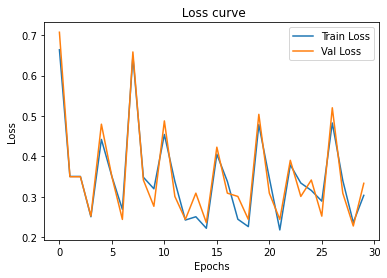

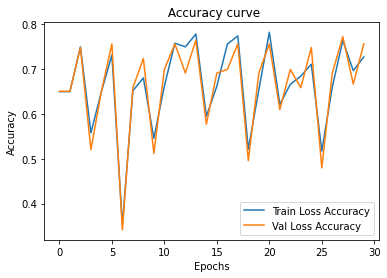

Test accuracy  0.6818181818181818


In [10]:
np.random.seed(0)
weights = np.random.rand(8,1)
learning_rate = 0.1
epochs = 30
val_accuracy, val_loss, weights = train(learning_rate, X_train, y_train, X_val, y_val, 
                                        weights, epochs, show_graphs = True)
test_predictions = predict(X_test, weights)
test_accuracy = accuracy_score(y_test, test_predictions)
print('Test accuracy ', test_accuracy)

y_test_predictions = predict(X_test, weights)
prf = precision_recall_fscore_support(y_test, y_test_predictions, average='binary')

In [11]:
print(prf)
print("Precision",prf[0])
print("Recall", prf[1])
print("F score",prf[2])

(0.6783216783216783, 0.97, 0.7983539094650205, None)
Precision 0.6783216783216783
Recall 0.97
F score 0.7983539094650205


In [12]:
# 1. Test accuracy
# 2. Precision, Recall, F-score : to find the effectivesness of our model

np.random.seed(0)
weights = np.random.rand(8,1)
learning_rate = 0.1
epochs = 100
val_accuracy, val_loss, weights = train(learning_rate, X_train, y_train, X_val, y_val, weights, epochs)
test_predictions = predict(X_test, weights)
test_accuracy = accuracy_score(y_test, test_predictions)
print('Test accuracy ', test_accuracy)

y_test_predictions = predict(X_test, weights)
precision_recall_fscore_support(y_test, y_test_predictions, average='binary')
# log_loss()



Test accuracy  0.6558441558441559


(0.6535947712418301, 1.0, 0.790513833992095, None)

Auc 0.826797385620915


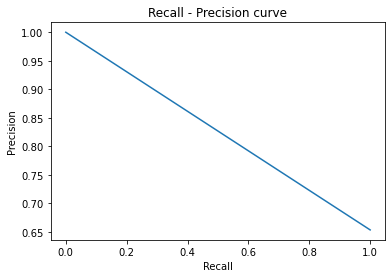

In [13]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_test, y_test_predictions)
plt.plot(recall,precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Recall - Precision curve")
plt.show
auc_val = auc(recall,precision)
print("Auc", auc_val)

In [14]:
#Confusion matrix
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_test_predictions).ravel()
print("Confusion matrix:",conf_mat)

true_n, false_p, false_n, true_p = conf_mat

print("True positive:",true_p, "\nTrue negative:",true_n, "\nFalse positive:", false_p, "\nFalse negative:", false_n)

Confusion matrix: [  1  53   0 100]
True positive: 100 
True negative: 1 
False positive: 53 
False negative: 0


range(0, 50)


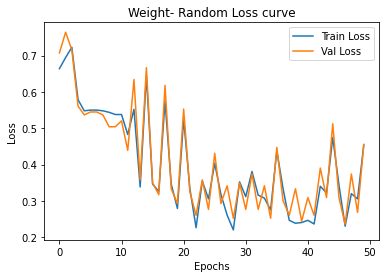

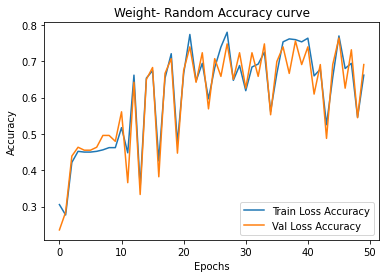

range(0, 50)


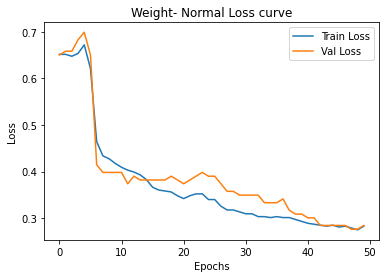

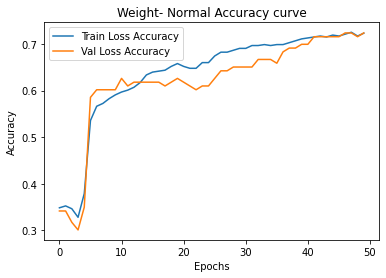

(0.7235772357723578,
 0.2845528455284553,
 array([[ 0.12316959],
        [-0.34526479],
        [ 0.56316421],
        [ 0.22241805],
        [ 0.04230958],
        [-1.14211079],
        [-0.10409958],
        [-0.3738572 ]]))

In [15]:
# Experiment 1: Weight
 
train_results = []
np.random.seed(0)
learning_rate = 0.001
epoch = 50

    # Random weight
weights = np.random.rand(8,1)
train(learning_rate, X_train, y_train, X_val, y_val, weights, epoch, show_graphs=True, graph_title = 'Weight- Random')

    # Normal distribution weight
np.random.seed(0)
learning_rate = 0.001
weights_normal = np.random.normal(size=(8,1))
train(learning_rate, X_train, y_train, X_val, y_val, weights_normal, epoch, show_graphs=True, graph_title = 'Weight- Normal')

range(0, 50)


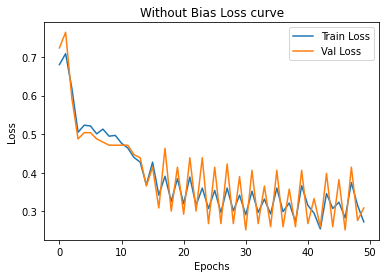

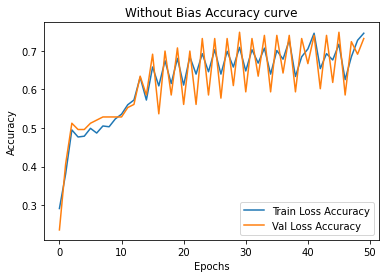

range(0, 50)


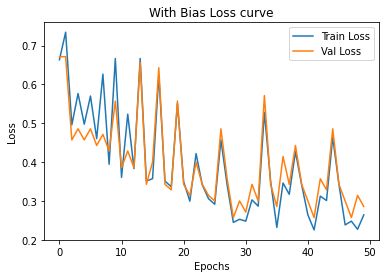

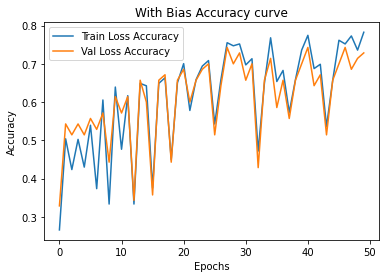

(0.7285714285714285,
 0.2857142857142857,
 array([[ 0.0542184 ],
        [-0.07220385],
        [-0.44962193],
        [ 0.1289137 ],
        [-0.04126103],
        [ 0.0302576 ],
        [-0.35960263],
        [-0.09249732],
        [-0.11359226]]))

In [16]:
# Experiment 2: Bias
    # Without bias
weights = np.random.rand(8,1)
train(learning_rate, X_train, y_train, X_val, y_val, weights, epoch, show_graphs=True, graph_title = 'Without Bias')
    # With bias
weights = np.random.rand(9,1)
train(learning_rate, X_train_bias, y_train_bias, X_val_bias, y_val_bias, weights, epoch, show_graphs=True, graph_title = 'With Bias')

range(0, 50)


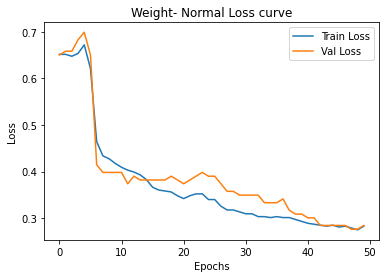

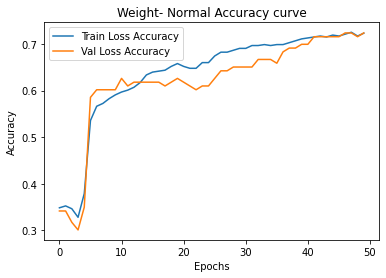

range(0, 50)


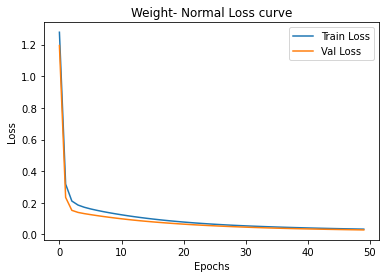

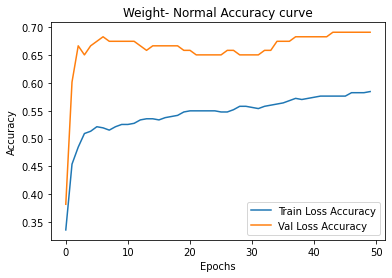

(0.6910569105691057,
 0.028066919041609826,
 array([[-0.09999831],
        [-0.00120061],
        [ 0.04086306],
        [ 0.33775948],
        [-0.13507514],
        [-0.20026283],
        [-0.12364759],
        [ 0.05506885]]))

In [17]:
# Experiment 3: Loss function

    #Zero one loss
np.random.seed(0)
weights_normal = np.random.normal(size=(8,1))
train(learning_rate, X_train, y_train, X_val, y_val, weights_normal, epoch, 
      show_graphs=True, graph_title = 'Weight- Normal',loss_function_name= "Zero one loss")

    #Perceptron loss
weights_normal = np.random.normal(size=(8,1))
train(learning_rate, X_train, y_train, X_val, y_val, weights_normal, epoch, 
      show_graphs=True, graph_title = 'Weight- Normal',loss_function_name= "Perceptron loss")

range(0, 50)


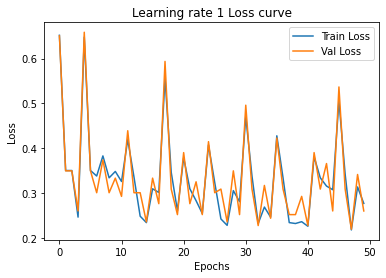

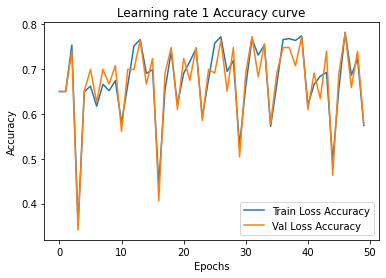

range(0, 50)


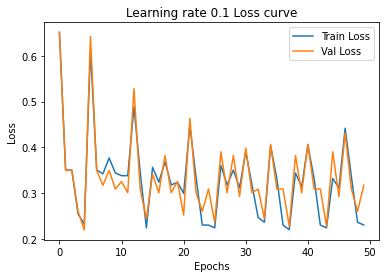

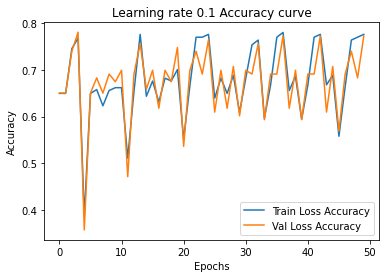

range(0, 50)


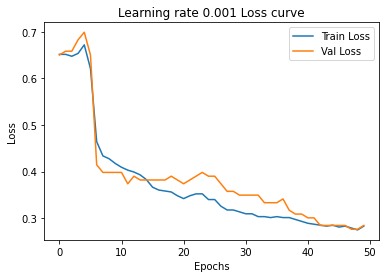

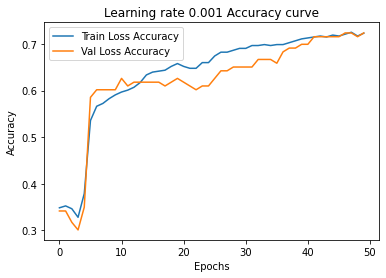

range(0, 50)


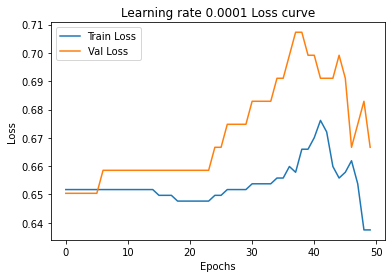

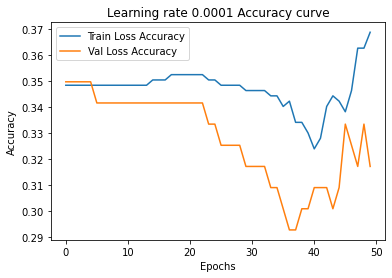

In [18]:
# Experiment 4: Learning rate
learning_rates = [1,0.1,0.001,0.0001]
np.random.seed(0)
weights_normal = np.random.normal(size=(8,1))
for ls in learning_rates:
    train(ls, X_train, y_train, X_val, y_val, 
          weights_normal, epoch, show_graphs = True, graph_title = 'Learning rate '+ str(ls))



range(0, 10)


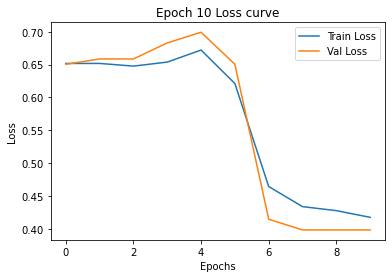

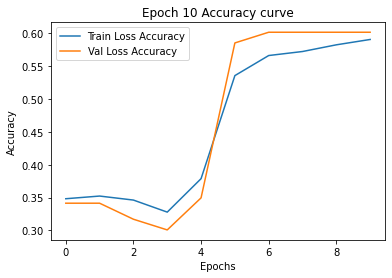

range(0, 20)


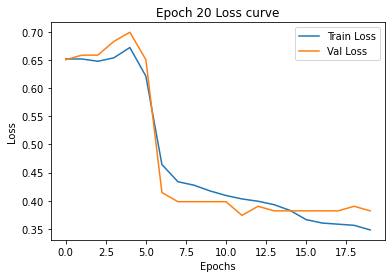

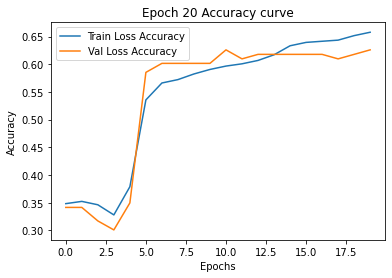

range(0, 30)


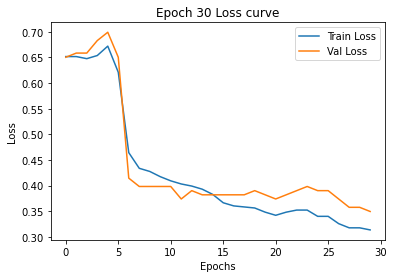

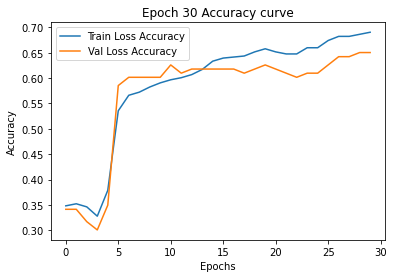

range(0, 40)


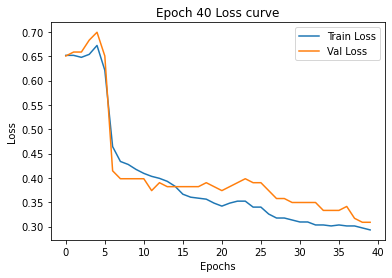

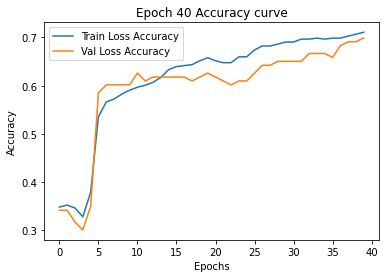

range(0, 50)


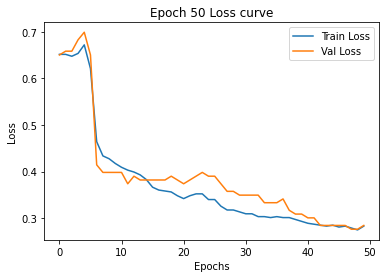

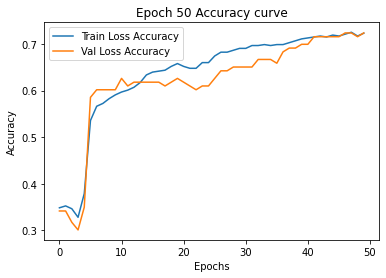

range(0, 60)


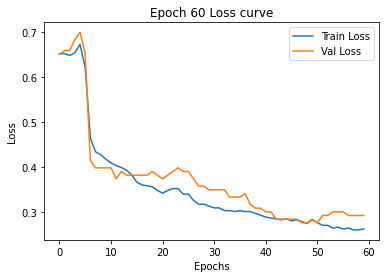

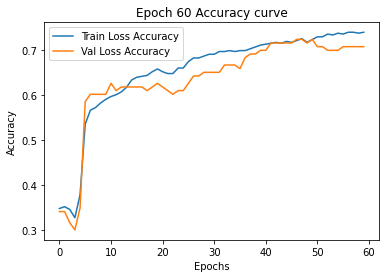

range(0, 80)


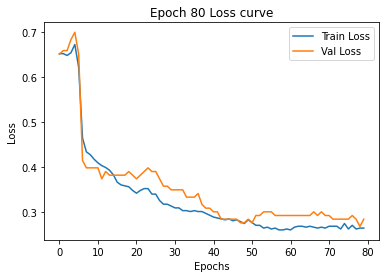

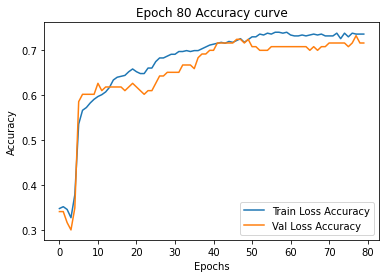

range(0, 100)


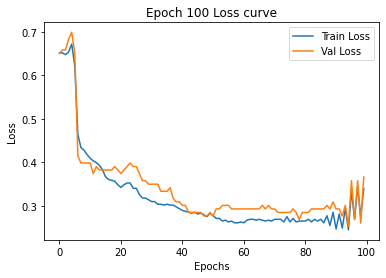

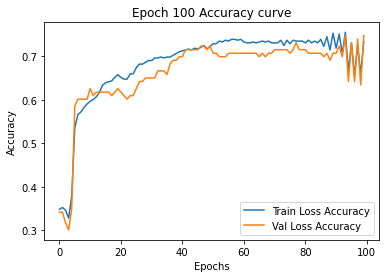

range(0, 250)


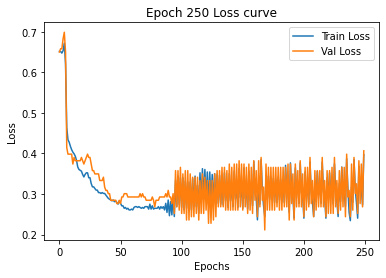

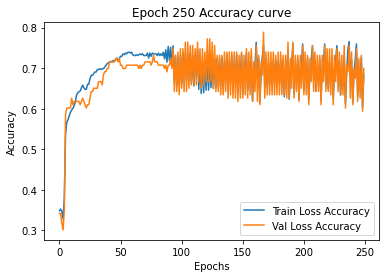

In [19]:
# Experiment 5: Epoch

epochs = [10,20,30,40,50,60,80,100,250]
learning_rate = 0.001
np.random.seed(0)
weights_normal = np.random.normal(size=(8,1))
for e in epochs:
    train(learning_rate, X_train, y_train, X_val, y_val, weights_normal, e, show_graphs=True, graph_title = 'Epoch '+ str(e))

